# Project: Wrangling and Analyze Data


## Table of Contents
<ul>
<li><a href="#gathering">Data Gathering</a></li>
<li><a href="#asses">Assessing Data</a></li>
<li><a href="#clean">Cleaning Data</a></li>
    <ul>
    <li><a href = "#quality">Quality Issues</a></li>
    <li><a href = "#tidy">Tidiness Issues</a></li>
    </ul>
<li><a href="#conclusions">Analyzing and Visualizing Data</a></li>
</ul>

In [1]:
# import required libraries
import pandas as pd
import requests
import tweepy
from tweepy import OAuthHandler
import json
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')

In [2]:
#helper functions
def df_size(df):
    """
    The method prints the number of rows and columns in a dataframe
    Parameter: df, the dataframe for which to print the size for
    """
    print(f"rows: {df.shape[0]}, columns: {df.shape[1]}")
    
def missing_vals_cols(df):
    """
    The method prints all columns with missing values
    Parameter: df, the dataframe to check the missing data from
    Return: the list of columns with missing values
    """
    return list(df[df.columns[df.isna().any()]])

def columns_list(df):
    """
    Return the columns list from a dataframe
    Parameter: df, the dataframe
    """
    print(list(df.columns))

<a id='gathering'></a>
## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [3]:
we_rate_dogs = pd.read_csv('twitter-archive-enhanced.csv')
we_rate_dogs.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_predictions = requests.get(url)

In [5]:
with open('image-predictions.tsv', mode='wb') as file:
    file.write(image_predictions.content)

In [6]:
image_predictions = pd.read_csv("image-predictions.tsv", sep='\t')

In [7]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [8]:
#reading data from the tweet-json.txt and saving it in a dataframa
cols_list = []
with open('tweet-json.txt', encoding='utf-8') as file:
    for line in file.readlines():
        line = json.loads(line) #load the line and convert to json dict
        #get the columns we will use
        tweet_id = line.get('id')
        retweet_count = line.get('retweet_count')
        fav_count = line.get('favorite_count')
        #store as a list of dictionaries
        cols_list.append({"tweet_id":tweet_id, "retweet_count":retweet_count, "fav_count":fav_count})
        
# Create DataFrame from the list of dictionaries
tweet_data = pd.DataFrame(cols_list, columns = ['tweet_id', 'retweet_count', 'fav_count'])
tweet_data = tweet_data.sort_values(["retweet_count", "fav_count"]).reset_index(drop=True)
tweet_data.head()

,tweet_id,retweet_count,fav_count
0,838085839343206401,0,150
1,707983188426153984,2,52
2,832088576586297345,3,72
3,870726314365509632,3,121
4,840698636975636481,3,197


<a id='asses'></a>
## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [9]:
we_rate_dogs

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [10]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [11]:
tweet_data.head()

,tweet_id,retweet_count,fav_count
0,838085839343206401,0,150
1,707983188426153984,2,52
2,832088576586297345,3,72
3,870726314365509632,3,121
4,840698636975636481,3,197


In [12]:
we_rate_dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
we_rate_dogs[we_rate_dogs["tweet_id"].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [14]:
we_rate_dogs.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
we_rate_dogs.source.unique()

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'], dtype=object)

In [16]:
# all my rating denominators are integers
we_rate_dogs["rating_denominator"].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [17]:
# all my rating numerators are integers
we_rate_dogs["rating_numerator"].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [18]:
# confirm the visualization ratings that are inaccurate
we_rate_dogs["text"].unique()[45]

'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'

In [19]:
we_rate_dogs.iloc[45]

tweet_id                                                     883482846933004288
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                             2017-07-08 00:28:19 +0000
source                        <a href="http://twitter.com/download/iphone" r...
text                          This is Bella. She hopes her smile made you sm...
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                 https://twitter.com/dog_rates/status/883482846...
rating_numerator                                                              5
rating_denominator                                                           10
name                                    

In [20]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [21]:
image_predictions[image_predictions["tweet_id"].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [22]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [23]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id         2354 non-null int64
retweet_count    2354 non-null int64
fav_count        2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [24]:
tweet_data[tweet_data.tweet_id.duplicated()]

,tweet_id,retweet_count,fav_count


### Quality issues
1. `we_rate_dogs data` contains retweets and replies, yet we only need original tweets
1. `we_rate_dogs data` has missing values
1. `we_rate_dogs data` incorrect representation of null values for columns name, doggo, floofer, pupper, puppo as they cannot be visualised with df.info()

1. `we_rate_dogs data` and `image_predictions_data` invalid names, underscores in the breeds columns

1. Conversion of data columns to their own data types.
1. `we_rate_dogs data` text column is not descriptive
1. `we_rate_dogs data` the source data is not well extracted to identify the source of the tweet
1. Drop columns not important for our analysis, as it contains the url and the source of the tweet
1. Inaccurate extraction of tweet numerators from text when they are decimals

### Tidiness issues
1. `we rate dogs data` doggo, floofer, pupper, puppo  must be one column as they identify the stage growth of a dog
1. Each dog has more than one prediction
1. Different tables yet they are all related

<a id='clean'></a>
## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [25]:
# Make copies of original pieces of data
df_we_rate_dogs = we_rate_dogs.copy()
df_tweet_data = tweet_data.copy()
df_image_preds = image_predictions.copy()

<a id='quality'></a>
### Quality Issues

### Issue #1: `we_rate_dogs` data retweets but we only need original tweets

#### Define: 
Drop all rows that contain retweets by using `in_reply_to_status_id` and `retweeted_status_id` columns

#### Code

In [26]:
df_size(df_we_rate_dogs)

rows: 2356, columns: 17


In [27]:
# number of retweets
print(f"the  number of retweets: {df_we_rate_dogs['in_reply_to_status_id'].isna().sum()}")

the  number of retweets: 2278


In [28]:
df_we_rate_dogs['retweeted_status_id'].isna().sum()

2175

In [29]:
df_we_rate_dogs[["in_reply_to_status_id", "retweeted_status_id"]] = df_we_rate_dogs[["in_reply_to_status_id", "retweeted_status_id"]].fillna("original tweets")

In [30]:
#get original tweets
df_we_rate_dogs = df_we_rate_dogs[df_we_rate_dogs["in_reply_to_status_id"] == "original tweets"]
df_we_rate_dogs = df_we_rate_dogs[df_we_rate_dogs["retweeted_status_id"] == "original tweets"]

#### Test

In [31]:
df_size(df_we_rate_dogs)#decreased rows thus we have removed the retweets

rows: 2097, columns: 17


In [32]:
df_we_rate_dogs[["in_reply_to_status_id", "retweeted_status_id"]].sample(20)

,in_reply_to_status_id,retweeted_status_id
1312,original tweets,original tweets
904,original tweets,original tweets
2122,original tweets,original tweets
881,original tweets,original tweets
2239,original tweets,original tweets
1674,original tweets,original tweets
297,original tweets,original tweets
1741,original tweets,original tweets
1323,original tweets,original tweets
914,original tweets,original tweets


In [33]:
df_we_rate_dogs[["in_reply_to_status_id", "retweeted_status_id"]].isna().sum()

in_reply_to_status_id    0
retweeted_status_id      0
dtype: int64

### Issue #2: `we_rate_dogs` data has missing values

#### Define:
1. Dropping columns with many missing values

#### Code

In [34]:
print(f"Original number of columns: {len(list(df_we_rate_dogs.columns))}")

Original number of columns: 17


In [35]:
# the list of columns with missing values
missing_vals_cols(df_we_rate_dogs)

['in_reply_to_user_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls']

In [36]:
#the shape of the dataframe before dropping
df_size(df_we_rate_dogs)
#drop the columns with null values
df_we_rate_dogs.dropna(axis=1, inplace=True)

rows: 2097, columns: 17


#### Test

In [37]:
# the list of columns with missing values
missing_vals_cols(df_we_rate_dogs)

[]

In [38]:
#confirm the size after dropping
df_size(df_we_rate_dogs)

rows: 2097, columns: 13


### Issue #3: `we_rate_dogs data` incorrect representation of null values for columns name, doggo, floofer, pupper, puppo as they cannot be visualised with df.info()

#### Define
Fixing the representation of null values, for doggo, floofer, pupper, and puppo instead of None's replace with the string null value, np.nan

#### Code

In [39]:
df_we_rate_dogs.head()

,tweet_id,in_reply_to_status_id,timestamp,source,text,retweeted_status_id,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,original tweets,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,original tweets,13,10,Phineas,None,None,None,None
1,892177421306343426,original tweets,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,original tweets,13,10,Tilly,None,None,None,None
2,891815181378084864,original tweets,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,original tweets,12,10,Archie,None,None,None,None
3,891689557279858688,original tweets,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,original tweets,13,10,Darla,None,None,None,None
4,891327558926688256,original tweets,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,original tweets,12,10,Franklin,None,None,None,None


In [40]:
stages = ["doggo","floofer","pupper","puppo"]

In [41]:
for stage in stages:
    print(f"{stage}: {df_we_rate_dogs[stage].value_counts()} \n")

doggo: None     2014
doggo      83
Name: doggo, dtype: int64 

floofer: None       2087
floofer      10
Name: floofer, dtype: int64 

pupper: None      1867
pupper     230
Name: pupper, dtype: int64 

puppo: None     2073
puppo      24
Name: puppo, dtype: int64 



In [42]:
df_we_rate_dogs[["doggo","floofer","pupper","puppo"]] = df_we_rate_dogs[["doggo","floofer","pupper","puppo"]].replace(regex="None", value=np.nan)

#### Test

In [43]:
for stage in stages:
    print(f"{stage}: {df_we_rate_dogs[stage].value_counts()}")

doggo: doggo    83
Name: doggo, dtype: int64
floofer: floofer    10
Name: floofer, dtype: int64
pupper: pupper    230
Name: pupper, dtype: int64
puppo: puppo    24
Name: puppo, dtype: int64


### Issue #4: `we_rate_dogs` Invalid names

#### Define
- For all the names that are invalid, we will replace with an invalid so that we avoid deleting any data for now, as the names might not be very important for our analysis
- Replace all underscores with a space

#### Code

In [44]:
# names that do not make a lot of sense, #False caused by our filling on None values
non_names = ['None','quite', 'space', 'infuriating', 'his', 'officially', 'light', 'getting', 
             'my', 'a', 'by', 'such', 'actually', 'mad', 'this', 'an', 'not', 'one', 
             'unacceptable', 'life', 'the', 'incredibly', 'just', 'very', 'old', 'all', 'None']

In [45]:
# replacing invalid names
df_we_rate_dogs[["name"]] = df_we_rate_dogs[["name"]].replace(non_names, "Invalid")

In [46]:
# converting all to lower cases
cols = ['p1', 'p2', 'p3']
for col in cols:
    df_image_preds[col] = df_image_preds[col].str.lower()

In [47]:
# replacing underscores with space
df_image_preds = df_image_preds.replace("_"," ", regex=True)

#### Test

In [48]:
print(df_we_rate_dogs[df_we_rate_dogs["name"].isin(non_names)])

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, timestamp, source, text, retweeted_status_id, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []


In [49]:
df_image_preds[["p1", "p2", "p3"]].head(20)

,p1,p2,p3
0,welsh springer spaniel,collie,shetland sheepdog
1,redbone,miniature pinscher,rhodesian ridgeback
2,german shepherd,malinois,bloodhound
3,rhodesian ridgeback,redbone,miniature pinscher
4,miniature pinscher,rottweiler,doberman
5,bernese mountain dog,english springer,greater swiss mountain dog
6,box turtle,mud turtle,terrapin
7,chow,tibetan mastiff,fur coat
8,shopping cart,shopping basket,golden retriever
9,miniature poodle,komondor,soft-coated wheaten terrier


### Issue #5: `we_rate_dogs data` drop unimportant  columns for our analysis

#### Define
- Delete columns we do not need for the analysis

#### Code

In [50]:
columns_list(df_we_rate_dogs)

['tweet_id', 'in_reply_to_status_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


In [51]:
drop_cols = ['in_reply_to_status_id', 'retweeted_status_id']
df_we_rate_dogs.drop(columns=drop_cols, inplace=True)

In [52]:
columns_list(df_image_preds)

['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']


In [53]:
df_image_preds.drop(columns=["jpg_url"],inplace=True)

In [54]:
columns_list(df_tweet_data)

['tweet_id', 'retweet_count', 'fav_count']


#### Test

In [55]:
columns_list(df_we_rate_dogs)

['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


In [56]:
columns_list(df_image_preds)

['tweet_id', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']


### Issue #5: Convert data columns to the correct data types

In [57]:
df_we_rate_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 83 non-null object
floofer               10 non-null object
pupper                230 non-null object
puppo                 24 non-null object
dtypes: int64(3), object(8)
memory usage: 196.6+ KB


In [58]:
df_we_rate_dogs["tweet_id"] = df_we_rate_dogs["tweet_id"].astype(str)
df_we_rate_dogs["timestamp"] = pd.to_datetime(df_we_rate_dogs["timestamp"], infer_datetime_format=True)

In [59]:
df_image_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
tweet_id    2075 non-null int64
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(3)
memory usage: 135.8+ KB


In [60]:
df_image_preds["tweet_id"] = df_image_preds["tweet_id"].astype(str)

In [61]:
df_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id         2354 non-null int64
retweet_count    2354 non-null int64
fav_count        2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [62]:
df_tweet_data["tweet_id"] = df_tweet_data["tweet_id"].astype(str)

#### Test

In [63]:
df_we_rate_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 83 non-null object
floofer               10 non-null object
pupper                230 non-null object
puppo                 24 non-null object
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 196.6+ KB


In [64]:
df_image_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
tweet_id    2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 135.8+ KB


In [65]:
df_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id         2354 non-null object
retweet_count    2354 non-null int64
fav_count        2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


### Issue #6: `we_rate_dogs data` Columns not descriptive

#### Define
Rename the text column to `tweet_content`,and the source to `tweet_source`

#### Code

In [66]:
df_we_rate_dogs.rename(columns={"text":"tweet_content", "source":"tweet_source"},inplace=True)

#df_we_rate_dogs[df_we_rate_dogs.text.str.contains(r"(?:\d+\.\d*\/\d+)")][['text', 
#'rating_numerator']]

In [67]:
df_we_rate_dogs.iloc[46]

tweet_id                                             882627270321602560
timestamp                                           2017-07-05 15:48:34
tweet_source          <a href="http://twitter.com/download/iphone" r...
tweet_content         This is Stanley. He has his first swim lesson ...
rating_numerator                                                     13
rating_denominator                                                   10
name                                                            Stanley
doggo                                                               NaN
floofer                                                             NaN
pupper                                                              NaN
puppo                                                               NaN
Name: 50, dtype: object

#### Test

In [68]:
columns_list(df_we_rate_dogs)

['tweet_id', 'timestamp', 'tweet_source', 'tweet_content', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


### Issue #7: the source data is not well extracted to identify the source of the tweet

#### Define
- find the unique values in the `tweet_source`column
- replace url with the tweet source

#### Code

In [69]:
df_we_rate_dogs["tweet_source"].unique()

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'], dtype=object)

In [70]:
df_we_rate_dogs['tweet_source'] = \
df_we_rate_dogs['tweet_source'].str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'iPhone')

In [71]:
df_we_rate_dogs['tweet_source'] = \
df_we_rate_dogs['tweet_source'].str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Web')

In [72]:
df_we_rate_dogs['tweet_source'] = \
df_we_rate_dogs['tweet_source'].str.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine')

In [73]:
df_we_rate_dogs['tweet_source'] = \
df_we_rate_dogs['tweet_source'].str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

#### Test

In [74]:
df_we_rate_dogs["tweet_source"].value_counts()

iPhone       1964
Vine           91
Web            31
TweetDeck      11
Name: tweet_source, dtype: int64

### Issue #7: Inaccurate extraction of tweet numerators from text when they are decimals

#### Define
Extract the tweets from the tweet_content column

#### Code

In [75]:
df_we_rate_dogs["rating_numerator"] = df_we_rate_dogs["rating_numerator"].astype(float)

In [76]:
df_we_rate_dogs[df_we_rate_dogs.tweet_content.str.contains(r"(?:\d+\.\d*\/\d+)")][['tweet_content', 
'rating_numerator']]

,tweet_content,rating_numerator
45,This is Bella. She hopes her smile made you sm...,5.0
695,"This is Logan, the Chow who lived. He solemnly...",75.0
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27.0
1712,Here we have uncovered an entire battalion of ...,26.0


#### Test

In [77]:
df_we_rate_dogs["rating_numerator"].value_counts()

12.0      486
10.0      436
11.0      413
13.0      287
9.0       153
8.0        98
7.0        52
14.0       38
5.0        34
6.0        32
3.0        19
4.0        16
2.0         9
1.0         5
24.0        1
27.0        1
84.0        1
0.0         1
420.0       1
75.0        1
80.0        1
60.0        1
44.0        1
26.0        1
144.0       1
88.0        1
121.0       1
99.0        1
204.0       1
1776.0      1
45.0        1
165.0       1
50.0        1
Name: rating_numerator, dtype: int64

<a id='tidy'></a>
### Tidiness Issues

### Issue #1: `we_rate_dogs data` doggo, floofer, pupper, puppo must be one column as they identify the stage growth of a dog

#### Define

Make a column of doggo, floofer, pupper, puppo into column and drop the columns

#### Code

In [78]:
stages

['doggo', 'floofer', 'pupper', 'puppo']

In [79]:
df_we_rate_dogs[stages] = df_we_rate_dogs[stages].astype(str)
# aggregate the columns, and replace the nan value with an empty strings so we visualize the dog stages
df_we_rate_dogs['dog_stages'] = df_we_rate_dogs[['doggo', 'floofer', 'pupper', 
                                                 'puppo']].agg(",".join, axis=1).map(lambda x: x.replace("nan,",""))

In [80]:
df_we_rate_dogs["dog_stages"].value_counts()

nan                  1761
pupper,nan            221
doggo,nan              72
puppo                  23
floofer,nan             9
doggo,pupper,nan        9
doggo,floofer,nan       1
doggo,puppo             1
Name: dog_stages, dtype: int64

In [81]:
#remove last nan
df_we_rate_dogs["dog_stages"] = df_we_rate_dogs["dog_stages"].map(lambda x: x.replace(",nan",""))

In [82]:
df_we_rate_dogs["dog_stages"].value_counts()

nan              1761
pupper            221
doggo              72
puppo              23
doggo,pupper        9
floofer             9
doggo,floofer       1
doggo,puppo         1
Name: dog_stages, dtype: int64

In [83]:
df_we_rate_dogs = df_we_rate_dogs.drop(columns=stages)

#### Test

In [84]:
df_we_rate_dogs.head()

,tweet_id,timestamp,tweet_source,tweet_content,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,nan
1,892177421306343426,2017-08-01 00:17:27,iPhone,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,nan
2,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,nan
3,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,nan
4,891327558926688256,2017-07-29 16:00:24,iPhone,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,nan


### Issue #2: Different tables yet they are all related

#### Define
Merge all the data into one table

#### Code

In [85]:
df_we_rate_dogs.head()

,tweet_id,timestamp,tweet_source,tweet_content,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,nan
1,892177421306343426,2017-08-01 00:17:27,iPhone,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,nan
2,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,nan
3,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,nan
4,891327558926688256,2017-07-29 16:00:24,iPhone,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,nan


In [86]:
# perform an inner join for we rate dogs with the image prediction dogs, this will mean we get only dogs that have images
df = df_we_rate_dogs.merge(df_image_preds, how="inner", on="tweet_id")

In [87]:
df.head()

,tweet_id,timestamp,tweet_source,tweet_content,rating_numerator,rating_denominator,name,dog_stages,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,nan,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,iPhone,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,nan,1,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,nan,1,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,nan,1,paper towel,0.170278,False,labrador retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,iPhone,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,nan,2,basset,0.555712,True,english springer,0.225770,True,german short-haired pointer,0.175219,True


In [88]:
# dropcolumns we do not need
cols = df.columns.difference(['timestamp', 'tweet_content', 'rating_denominator', 'name'])

df = df[cols]

df.head()

,dog_stages,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating_numerator,tweet_id,tweet_source
0,nan,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,13.0,892420643555336193,iPhone
1,nan,1,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,13.0,892177421306343426,iPhone
2,nan,1,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,12.0,891815181378084864,iPhone
3,nan,1,paper towel,0.170278,False,labrador retriever,0.168086,True,spatula,0.040836,False,13.0,891689557279858688,iPhone
4,nan,2,basset,0.555712,True,english springer,0.225770,True,german short-haired pointer,0.175219,True,12.0,891327558926688256,iPhone


In [89]:
#this will help us get only original tweets, those present in the tweet data
df = df_tweet_data.merge(df, how="inner", on="tweet_id")
df.head()

,tweet_id,retweet_count,fav_count,dog_stages,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating_numerator,tweet_source
0,666102155909144576,16,81,nan,1,english setter,0.298617,True,newfoundland,0.149842,True,borzoi,0.133649,True,11.0,iPhone
1,666447344410484738,23,107,nan,1,curly-coated retriever,0.322084,True,giant schnauzer,0.287955,True,labrador retriever,0.166331,True,9.0,iPhone
2,668291999406125056,34,264,nan,1,web site,0.995535,False,skunk,0.001363,False,badger,0.000686,False,10.0,iPhone
3,666268910803644416,37,108,nan,1,desktop computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False,10.0,iPhone
4,666049248165822465,41,111,nan,1,miniature pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,5.0,iPhone


#### Test

In [90]:
# check if we have all the columns we need
df.head()

,tweet_id,retweet_count,fav_count,dog_stages,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating_numerator,tweet_source
0,666102155909144576,16,81,nan,1,english setter,0.298617,True,newfoundland,0.149842,True,borzoi,0.133649,True,11.0,iPhone
1,666447344410484738,23,107,nan,1,curly-coated retriever,0.322084,True,giant schnauzer,0.287955,True,labrador retriever,0.166331,True,9.0,iPhone
2,668291999406125056,34,264,nan,1,web site,0.995535,False,skunk,0.001363,False,badger,0.000686,False,10.0,iPhone
3,666268910803644416,37,108,nan,1,desktop computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False,10.0,iPhone
4,666049248165822465,41,111,nan,1,miniature pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,5.0,iPhone


In [91]:
#confirm there are duplicates
df["tweet_id"].duplicated().sum()

0

In [92]:
# are all the dogs rated
df["rating_numerator"].isna().sum()

0

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [93]:
df.to_csv("twitter_archive_master.csv", index=False)

<a id='conclusions'></a>
## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [94]:
df = pd.read_csv("twitter_archive_master.csv")
df.head()

,tweet_id,retweet_count,fav_count,dog_stages,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating_numerator,tweet_source
0,666102155909144576,16,81,NaN,1,english setter,0.298617,True,newfoundland,0.149842,True,borzoi,0.133649,True,11.0,iPhone
1,666447344410484738,23,107,NaN,1,curly-coated retriever,0.322084,True,giant schnauzer,0.287955,True,labrador retriever,0.166331,True,9.0,iPhone
2,668291999406125056,34,264,NaN,1,web site,0.995535,False,skunk,0.001363,False,badger,0.000686,False,10.0,iPhone
3,666268910803644416,37,108,NaN,1,desktop computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False,10.0,iPhone
4,666049248165822465,41,111,NaN,1,miniature pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,5.0,iPhone


In [95]:
df.describe()

,tweet_id,retweet_count,fav_count,img_num,p1_conf,p2_conf,p3_conf,rating_numerator
count,1.971000e+03,1971.000000,1971.000000,1971.000000,1971.000000,1.971000e+03,1.971000e+03,1971.000000
mean,7.360418e+17,2784.449518,8949.106545,1.201928,0.594558,1.345850e-01,6.016556e-02,12.223237
std,6.752810e+16,4697.662893,12267.799790,0.559020,0.272126,1.010527e-01,5.094156e-02,41.634034
min,6.660209e+17,16.000000,81.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,0.000000
25%,6.758656e+17,628.500000,1997.000000,1.000000,0.363091,5.339800e-02,1.608055e-02,10.000000
50%,7.088343e+17,1367.000000,4147.000000,1.000000,0.587764,1.173970e-01,4.944380e-02,11.000000
75%,7.880951e+17,3239.000000,11402.500000,1.000000,0.847827,1.955655e-01,9.153815e-02,12.000000
max,8.924206e+17,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,1776.000000


### Insights:
1. The dog that has been retweeted the most had 79515 retweets and the one that has been retweeted the least has 633 retweets

2. There is a dog that has no favourites, as the minimum fav_count is 0, and the most liked dog has 132810 fav_count

3. Each dog has at least one image, and the maximum number of images per dog is 4

4. The maximum rated numerator is 1776 and the least is 0

### Visualization

In [96]:
df.head()

,tweet_id,retweet_count,fav_count,dog_stages,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating_numerator,tweet_source
0,666102155909144576,16,81,NaN,1,english setter,0.298617,True,newfoundland,0.149842,True,borzoi,0.133649,True,11.0,iPhone
1,666447344410484738,23,107,NaN,1,curly-coated retriever,0.322084,True,giant schnauzer,0.287955,True,labrador retriever,0.166331,True,9.0,iPhone
2,668291999406125056,34,264,NaN,1,web site,0.995535,False,skunk,0.001363,False,badger,0.000686,False,10.0,iPhone
3,666268910803644416,37,108,NaN,1,desktop computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False,10.0,iPhone
4,666049248165822465,41,111,NaN,1,miniature pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,5.0,iPhone


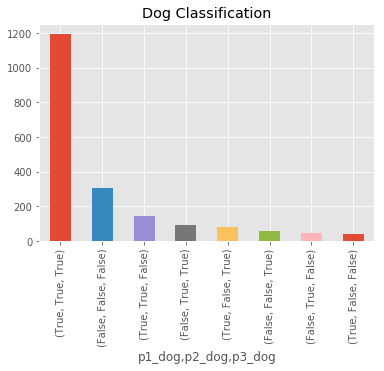

In [97]:
df.groupby(["p1_dog","p2_dog","p3_dog"]).count()["fav_count"].sort_values(ascending=False).plot(kind="bar", title="Dog Classification");

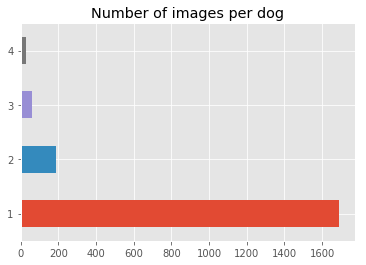

In [98]:
df["img_num"].value_counts().plot(kind="barh", title="Number of images per dog");

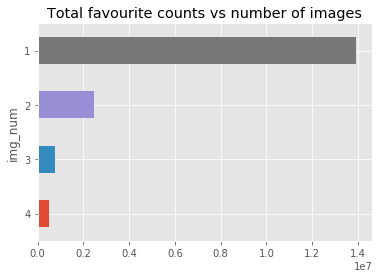

In [99]:
df.groupby(["img_num"]).sum()["fav_count"].sort_values(ascending=True).plot(kind="barh", \
                                                                            title="Total favourite counts vs number of images");

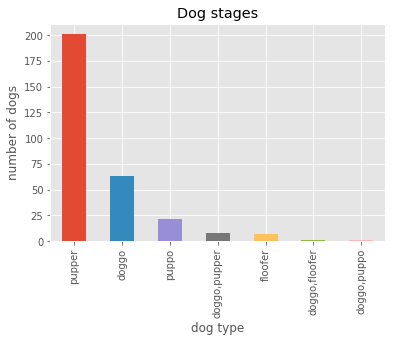

In [100]:
df.dog_stages.value_counts().plot(kind="bar", title="Dog stages")
plt.ylabel("number of dogs")
plt.xlabel("dog type");

1. Majority of dogs are puppers, followed by doggos's
1. There is one dog of type doggo, floofer and doggo,puppo 

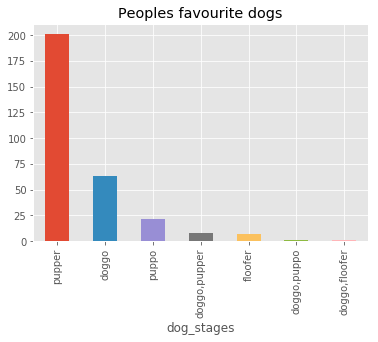

In [101]:
df.groupby(["dog_stages"]).count()["fav_count"].sort_values(ascending=False).plot(kind="bar")
plt.title("Peoples favourite dogs");

In [102]:
df.groupby(["dog_stages"]).sum()["fav_count"].sort_values(ascending=False)

dog_stages
pupper           1457356.0
doggo            1219452.0
puppo             474806.0
doggo,pupper      105759.0
floofer            92442.0
doggo,puppo        47844.0
doggo,floofer      17169.0
Name: fav_count, dtype: float64

The most favoured dog is the Pupper